In [1]:
# !pip install perceval-quandela
# !pip install tqdm

In [2]:
import perceval as pcvl
import numpy as np
from math import comb
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm as tqdm
from perceval.simulators import Simulator
from perceval.backends import SLOSBackend


In [3]:
print(pcvl.__version__)

0.9.1


In [4]:
nphotons = 4

random_seed = np.random.randint(0, 10000)
# random_seed = 8468
np.random.seed(random_seed)
print("Random Seed:", random_seed)

Random Seed: 7753


In [5]:
#Initial Values
# del1, w1, del2, w2, del3, w3, P_e1, P_e2, P_e3
del1_val0, w1_val0, del2_val0, w2_val0, del3_val0, w3_val0, P_e1_val, P_e2, P_e3 = [0.0626, 1, 1.0567, 1, 0.9449, 1, 1.43824549482149, 1.040964945989, 0.757527164510807]


In [6]:
# Differential equation parameters

# Ws, H1, H2, H3, D1, D2, D3
Ws, H1, H2, H3, D1, D2, D3 = (376.9911, 23.64, 6.4, 3.01, 23.64, 6.4, 3.01)

# P_m1, P_m2, P_m3, X_d_p1, X_d_p2, X_d_p3
P_m1, P_m2, P_m3, X_d_p1, X_d_p2, X_d_p3 = (0.7164, 1.63, 0.85, 0.0608, 0.1198, 0.1813)

# e_q_p1, e_q_p2, e_q_p3, R_a1, R_a2, R_a3
e_q_p1, e_q_p2, e_q_p3, R_a1, R_a2, R_a3 = (1.0566, 1.0502, 1.0170, 0, 0, 0)

# a11-a26 of Y
a_11, a_12, a_13, a_14, a_15, a_16, a_21, a_22, a_23, a_24, a_25, a_26 = (0.8455, 2.9883, 0.2871, -1.5129, 0.2096, -1.2256, -2.9883, 0.8455, 1.5129, 0.2871, 1.2256, 0.2096)

# a31-a46 of Y
a_31, a_32, a_33, a_34, a_35, a_36, a_41, a_42, a_43, a_44, a_45, a_46 = (0.2871, -1.5129, 0.4200, 2.7239, 0.2133, -1.0879, 1.5129, 0.2871, -2.7239, 0.4200, 1.0879, 0.2133)

# a51-a56 of Y
a_51, a_52, a_53, a_54, a_55, a_56 = (0.2096, -1.2256, 0.2133, -1.0879, 0.2770, 2.3681)

# a61-a66 of Y
a_61, a_62, a_63, a_64, a_65, a_66 = (1.2256, 0.2096, 1.0879, 0.2133, -2.3681, 0.2770)

In [7]:
cos = np.cos
sin = np.sin

In [8]:
def f1(del1,del2,del3):
   return (-R_a1*(a_11*e_q_p1*cos(del1) + a_12*e_q_p1*sin(del1) + a_13*e_q_p2*cos(del2) + a_14*e_q_p2*sin(del2) 
            + a_15*e_q_p3*cos(del3) + a_16*e_q_p3*sin(del3)) + X_d_p1*(a_21*e_q_p1*cos(del1) + a_22*e_q_p1*sin(del1) 
            + a_23*e_q_p2*cos(del2) + a_24*e_q_p2*sin(del2) + a_25*e_q_p3*cos(del3) + a_26*e_q_p3*sin(del3)) 
            + e_q_p1*cos(del1))*(a_11*e_q_p1*cos(del1) + a_12*e_q_p1*sin(del1) + a_13*e_q_p2*cos(del2) + a_14*e_q_p2*sin(del2) 
            + a_15*e_q_p3*cos(del3) + a_16*e_q_p3*sin(del3)) + (-R_a1*(a_21*e_q_p1*cos(del1) + a_22*e_q_p1*sin(del1) 
            + a_23*e_q_p2*cos(del2) + a_24*e_q_p2*sin(del2) + a_25*e_q_p3*cos(del3) + a_26*e_q_p3*sin(del3)) 
            - X_d_p1*(a_11*e_q_p1*cos(del1) + a_12*e_q_p1*sin(del1) + a_13*e_q_p2*cos(del2) + a_14*e_q_p2*sin(del2) 
            + a_15*e_q_p3*cos(del3) + a_16*e_q_p3*sin(del3)) + e_q_p1*sin(del1))*(a_21*e_q_p1*cos(del1) + a_22*e_q_p1*sin(del1) 
            + a_23*e_q_p2*cos(del2) + a_24*e_q_p2*sin(del2) + a_25*e_q_p3*cos(del3) + a_26*e_q_p3*sin(del3))

def f2(del1,del2,del3):
   return (-R_a2*(a_31*e_q_p1*cos(del1) + a_32*e_q_p1*sin(del1) + a_33*e_q_p2*cos(del2) + a_34*e_q_p2*sin(del2) 
            + a_35*e_q_p3*cos(del3) + a_36*e_q_p3*sin(del3)) + X_d_p2*(a_41*e_q_p1*cos(del1) + a_42*e_q_p1*sin(del1) 
            + a_43*e_q_p2*cos(del2) + a_44*e_q_p2*sin(del2) + a_45*e_q_p3*cos(del3) + a_46*e_q_p3*sin(del3)) 
            + e_q_p2*cos(del2))*(a_31*e_q_p1*cos(del1) + a_32*e_q_p1*sin(del1) + a_33*e_q_p2*cos(del2) + a_34*e_q_p2*sin(del2) 
            + a_35*e_q_p3*cos(del3) + a_36*e_q_p3*sin(del3)) + (-R_a2*(a_41*e_q_p1*cos(del1) + a_42*e_q_p1*sin(del1) 
            + a_43*e_q_p2*cos(del2) + a_44*e_q_p2*sin(del2) + a_45*e_q_p3*cos(del3) + a_46*e_q_p3*sin(del3)) 
            - X_d_p2*(a_31*e_q_p1*cos(del1) + a_32*e_q_p1*sin(del1) + a_33*e_q_p2*cos(del2) + a_34*e_q_p2*sin(del2) 
            + a_35*e_q_p3*cos(del3) + a_36*e_q_p3*sin(del3)) + e_q_p2*sin(del2))*(a_41*e_q_p1*cos(del1) + a_42*e_q_p1*sin(del1) 
            + a_43*e_q_p2*cos(del2) + a_44*e_q_p2*sin(del2) + a_45*e_q_p3*cos(del3) + a_46*e_q_p3*sin(del3))

def f3(del1,del2,del3):
    return (-R_a3*(a_51*e_q_p1*cos(del1) + a_52*e_q_p1*sin(del1) + a_53*e_q_p2*cos(del2) + a_54*e_q_p2*sin(del2) 
            + a_55*e_q_p3*cos(del3) + a_56*e_q_p3*sin(del3)) + X_d_p3*(a_61*e_q_p1*cos(del1) + a_62*e_q_p1*sin(del1) 
            + a_63*e_q_p2*cos(del2) + a_64*e_q_p2*sin(del2) + a_65*e_q_p3*cos(del3) + a_66*e_q_p3*sin(del3)) 
            + e_q_p3*cos(del3))*(a_51*e_q_p1*cos(del1) + a_52*e_q_p1*sin(del1) + a_53*e_q_p2*cos(del2) + a_54*e_q_p2*sin(del2) 
            + a_55*e_q_p3*cos(del3) + a_56*e_q_p3*sin(del3)) + (-R_a3*(a_61*e_q_p1*cos(del1) + a_62*e_q_p1*sin(del1) 
            + a_63*e_q_p2*cos(del2) + a_64*e_q_p2*sin(del2) + a_65*e_q_p3*cos(del3) + a_66*e_q_p3*sin(del3)) 
            - X_d_p3*(a_51*e_q_p1*cos(del1) + a_52*e_q_p1*sin(del1) + a_53*e_q_p2*cos(del2) + a_54*e_q_p2*sin(del2) 
            + a_55*e_q_p3*cos(del3) + a_56*e_q_p3*sin(del3)) + e_q_p3*sin(del3))*(a_61*e_q_p1*cos(del1) + a_62*e_q_p1*sin(del1) 
            + a_63*e_q_p2*cos(del2) + a_64*e_q_p2*sin(del2) + a_65*e_q_p3*cos(del3) + a_66*e_q_p3*sin(del3))

In [9]:
def DE1(delta1,delta2,delta3,delta1_prime,delta1_double_prime):
    right_hand = (Ws/2*H1)*(P_m1-f1(delta1,delta2,delta3)-D1*delta1_prime)
    return delta1_double_prime - right_hand

def DE2(delta1,delta2,delta3,delta2_prime,delta2_double_prime):
    right_hand = (Ws/2*H2)*(P_m2-f2(delta1,delta2,delta3)-D2*delta2_prime)
    return delta2_double_prime - right_hand

def DE3(delta1,delta2,delta3,delta3_prime,delta3_double_prime):
    right_hand = (Ws/2*H3)*(P_m3-f3(delta1,delta2,delta3)-D3*delta3_prime)
    return delta3_double_prime - right_hand

In [10]:
# # Boundary condition (f(x_0)=f_0)
# x_0 = 0
# f_0 = np.sin(0)

In [11]:
# Modeling parameters
n_grid = 10    # number of grid points of the discretized differential equation
range_min = 0  # minimum of the interval on which we wish to approximate our function
range_max = 0.2  # maximum of the interval on which we wish to approximate our function
# X = np.linspace(range_min, range_max-range_min, n_grid)  # Optimisation grid
t_data = np.linspace(range_min, range_max, n_grid)
dt = t_data[1]-t_data[0]

In [12]:
# Parameters of the quantum machine learning procedure
N = nphotons              # Number of photons
m = nphotons              # Number of modes
eta = 5                   # weight granted to the initial condition
a = 200                   # Approximate boundaries of the interval that the image of the trial function can cover
fock_dim = comb(N + m - 1, N)
# lambda coefficients for all the possible outputs
lambda_random_1 = 2 * a * np.random.rand(fock_dim) - a
lambda_random_2 = 2 * a * np.random.rand(fock_dim) - a
lambda_random_3 = 2 * a * np.random.rand(fock_dim) - a

# dx serves for the numerical differentiation of f
# dx = (range_max-range_min) / (n_grid - 1)

In [13]:
# Input state with N photons and m modes
input_state = pcvl.BasicState([1]*N+[0]*(m-N))
print(input_state)

|1,1,1,1>


In [14]:

"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters = np.random.normal(size=3*4*m**2)

px = pcvl.P("px")

# c1 = pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[:2 * m ** 2]), name="W1_1")\
#      // (0, pcvl.PS(px))\
#      // pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[2 * m ** 2:4 * m ** 2]), name="W2_1")

# c2 = pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[4 * m ** 2:6 * m ** 2]), name="W1_2")\
#      // (0, pcvl.PS(px))\
#      // pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[6 * m ** 2:8 * m ** 2]), name="W2_2")

# c3 = pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[8 * m ** 2:10 * m ** 2]), name="W1_3")\
#      // (0, pcvl.PS(px))\
#      // pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[10 * m ** 2:12 * m ** 2]), name="W2_3")


backend1 = pcvl.BackendFactory().get_backend("SLOS")
backend1.set_circuit(pcvl.Unitary(pcvl.Matrix.random_unitary(m)))
backend1.preprocess([input_state])

backend2 = pcvl.BackendFactory().get_backend("SLOS")
backend2.set_circuit(pcvl.Unitary(pcvl.Matrix.random_unitary(m)))
backend2.preprocess([input_state])

backend3 = pcvl.BackendFactory().get_backend("SLOS")
backend3.set_circuit(pcvl.Unitary(pcvl.Matrix.random_unitary(m)))
backend3.preprocess([input_state])

# pcvl.pdisplay(c)

True

In [15]:
def computation(params):
    global current_loss
    global computation_count
    "compute the loss function of a given differential equation in order for it to be optimized"
    computation_count += 1

    loss_i = 0 


    coefs1 = lambda_random_1  # coefficients of the M observable 1
    coefs2 = lambda_random_2  # coefficients of the M observable 2
    coefs3 = lambda_random_3  # coefficients of the M observable 3

    # initial condition with the two universal interferometers and the phase shift in the middle

    U_1_1 = pcvl.Matrix.random_unitary(m, params[:2 * m ** 2])
    U_2_1 = pcvl.Matrix.random_unitary(m, params[2 * m ** 2:4 * m ** 2])

    U_1_2 = pcvl.Matrix.random_unitary(m, params[4 * m ** 2:6 * m ** 2])
    U_2_2 = pcvl.Matrix.random_unitary(m, params[6 * m ** 2:8 * m ** 2])

    U_1_3 = pcvl.Matrix.random_unitary(m, params[8 * m ** 2:10 * m ** 2])
    U_2_3 = pcvl.Matrix.random_unitary(m, params[10 * m ** 2:12 * m ** 2])




    px = pcvl.P("x")
    c1 = pcvl.Unitary(U_2_1) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1_1)
    c2 = pcvl.Unitary(U_2_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1_2)
    c3 = pcvl.Unitary(U_2_3) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1_3)

    px.set_value(np.pi * range_min)
    # U = c.compute_unitary(use_symbolic=False)
    # backend.U = U

    backend1.set_circuit(c1)
    backend2.set_circuit(c2)
    backend3.set_circuit(c3)

    delta_0_1 = np.sum(np.multiply(backend1.all_prob(input_state), coefs1))
    delta_0_2 = np.sum(np.multiply(backend2.all_prob(input_state), coefs2))
    delta_0_3 = np.sum(np.multiply(backend3.all_prob(input_state), coefs3))


    # loss=0


    # Y[0] is before the domain we are interested in (used for differentiation), x_0 is at Y[1]
    Y1 = np.zeros(n_grid + 2)
    Y2 = np.zeros(n_grid + 2)
    Y3 = np.zeros(n_grid + 2)

    # x_0 is at the beginning of the domain, already calculated
    Y1[1] = delta_0_1
    Y2[1] = delta_0_2
    Y3[1] = delta_0_3

    # px.set_value(np.pi * (range_min - dt)/range_max)
    px.set_value(np.pi * (range_min - dt)/1)
    # backend.U = c.compute_unitary(use_symbolic=False)
    backend1.set_circuit(c1)
    backend2.set_circuit(c2)
    backend3.set_circuit(c3)
    Y1[0] = np.sum(np.multiply(backend1.all_prob(input_state), coefs1))
    Y2[0] = np.sum(np.multiply(backend2.all_prob(input_state), coefs2))
    Y3[0] = np.sum(np.multiply(backend3.all_prob(input_state), coefs3))


    for i in range(1, n_grid):
        x = t_data[i]
        # px.set_value(np.pi * x/range_max)
        px.set_value(np.pi * x/1)
        # backend.U = c.compute_unitary(use_symbolic=False)
        backend1.set_circuit(c1)
        backend2.set_circuit(c2)
        backend3.set_circuit(c3)
        Y1[i + 1] = np.sum(np.multiply(backend1.all_prob(input_state), coefs1))
        Y2[i + 1] = np.sum(np.multiply(backend2.all_prob(input_state), coefs2))
        Y3[i + 1] = np.sum(np.multiply(backend3.all_prob(input_state), coefs3))

    px.set_value(np.pi * (range_max + dt)/1)
    # backend.U = c.compute_unitary(use_symbolic=False)
    backend1.set_circuit(c1)
    backend2.set_circuit(c2)
    backend3.set_circuit(c3)
    Y1[n_grid + 1] = np.sum(np.multiply(backend1.all_prob(input_state), coefs1))
    Y2[n_grid + 1] = np.sum(np.multiply(backend2.all_prob(input_state), coefs2))
    Y3[n_grid + 1] = np.sum(np.multiply(backend3.all_prob(input_state), coefs3))


    # Differentiation
    Y_prime_1 = (Y1[2:] - Y1[:-2])/(2*dt)
    Y_prime_2 = (Y2[2:] - Y2[:-2])/(2*dt)
    Y_prime_3 = (Y3[2:] - Y3[:-2])/(2*dt)
    omega_0_1 = (1/Ws)*Y_prime_1[0]+1
    omega_0_2 = (1/Ws)*Y_prime_2[0]+1
    omega_0_3 = (1/Ws)*Y_prime_3[0]+1

    Y_zegond1 = (Y_prime_1[2:] - Y_prime_1[:-2])/(2*dt)
    Y_zegond2 = (Y_prime_2[2:] - Y_prime_2[:-2])/(2*dt)
    Y_zegond3 = (Y_prime_3[2:] - Y_prime_3[:-2])/(2*dt)

    # print(Y1[2:-2])
    # print(Y2[2:-2])
    # print(Y3[2:-2])
    # raise Exception

    loss_i_DE1 = np.sum((DE1(delta1=Y1[2:-2],delta2=Y2[2:-2],delta3=Y3[2:-2],delta1_prime=Y_prime_1[1:-1],delta1_double_prime=Y_zegond1)**2))
    loss_i_DE2 = np.sum((DE2(delta1=Y1[2:-2],delta2=Y2[2:-2],delta3=Y3[2:-2],delta2_prime=Y_prime_2[1:-1],delta2_double_prime=Y_zegond2)**2))
    loss_i_DE3 = np.sum((DE3(delta1=Y1[2:-2],delta2=Y2[2:-2],delta3=Y3[2:-2],delta3_prime=Y_prime_3[1:-1],delta3_double_prime=Y_zegond3)**2))
    loss_i = loss_i_DE1 + loss_i_DE2 + loss_i_DE3

    loss_b = 0
    loss_b += eta * (omega_0_1 - w1_val0) ** 2 * len(t_data)
    loss_b += eta * (omega_0_2 - w2_val0) ** 2 * len(t_data)
    loss_b += eta * (omega_0_3 - w3_val0) ** 2 * len(t_data)

    loss_b += eta * (delta_0_1 - del1_val0) ** 2 * len(t_data)
    loss_b += eta * (delta_0_2 - del2_val0) ** 2 * len(t_data)
    loss_b += eta * (delta_0_3 - del3_val0) ** 2 * len(t_data)

    # loss = loss_i+loss_b

    current_loss = (loss_i+loss_b) / len(t_data)
    return current_loss

In [16]:
a = [1,2,3,4,5,6,7,8]
print(a[2:])
print(a[:-2])
print(a[2:-2])


[3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6]
[3, 4, 5, 6]


In [17]:
def callbackF(parameters):
    """callback function called by scipy.optimize.minimize allowing to monitor progress"""
    global current_loss
    global computation_count
    global loss_evolution
    global start_time
    global best_param

    now = time.time()
    pbar.set_description("M= %d Loss: %0.5f #computations: %d elapsed: %0.5f" %
                         (m, current_loss, computation_count, now-start_time))
    pbar.update(1)
    loss_evolution.append((current_loss, now-start_time))
    computation_count = 0
    start_time = now
    best_param = parameters

In [18]:

# best_param = np.load('seed=8468 n_photon=4.npy')


In [19]:
computation_count = 0
current_loss = 0
start_time = time.time()
loss_evolution = []

pbar = tqdm.tqdm()
res = minimize(computation, parameters, callback=callbackF, method='BFGS', options={'gtol': 1E-2})

0it [00:00, ?it/s]

M= 4 Loss: 224631.33929 #computations: 1158 elapsed: 8.08163: : 103it [03:27,  4.34s/it]   

In [20]:
# print("Unitary parameters", res.x)
print("Unitary parameters", best_param)
np.save('seed='+str(random_seed)+' n_photon='+str(nphotons)+'.npy', best_param)


Unitary parameters [-0.36012682  0.98541362  0.24435965 -0.14387104  0.27940407 -0.25834298
  0.91881466 -0.76316784  0.60013984 -1.14379296 -1.23892397 -1.07921288
 -0.2585949  -1.07809164  0.38591719 -0.11034621  1.20943061  0.20752209
  0.30224594 -1.18094281 -1.47578483  1.5692563   1.28406955  1.32581081
 -0.48668719  1.24701685 -1.37848332 -0.44247585  0.218317   -1.37286139
  0.46385669 -0.35325783 -0.77996505  0.57466694 -0.33682817 -0.891179
 -1.22434307  2.09266285  0.02577582  1.26078327  1.36109179  0.71704032
 -1.72743569  0.11528742  0.53123536 -1.39486639  2.86534278  0.78513803
 -1.45672036 -0.40187474  0.984286    1.05771089  1.30125565 -0.20395202
  1.49754489  0.31745988  0.05976168  0.94458644 -0.03732263  0.44097842
  1.26667863  0.06974284 -0.45851934 -0.96182148  1.54738843 -0.58705758
  0.6572675  -1.43476132  0.15790049  0.06524983  0.24217485 -0.11526534
 -0.6799628   1.3289126   1.60055206  0.37145049 -0.46328161  0.4820927
 -2.46060631  0.96684801  0.8838620

In [21]:
def plot_solution(m, N, X, optim_params, lambda_random,label):
    Y = []
    U_1 = pcvl.Matrix.random_unitary(m, optim_params[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, optim_params[2 * m ** 2:])
    px = pcvl.P("x")
    c = pcvl.Unitary(U_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1)

    for x in X:
        px.set_value(np.pi * x/range_max)
        # U = c.compute_unitary(use_symbolic=False)
        # backend.U = U
        backend.set_circuit(c)
        f_theta = np.sum(np.multiply(backend.all_prob(input_state), lambda_random))
        Y.append(f_theta)

    
    plt.plot(X, Y, label=label+" Approximation with {} photons".format(N))
    return Y

In [22]:
def calculate_deltas(m, t, params):
    Y1 = []
    Y2 = []
    Y3 = []
    U_1_1 = pcvl.Matrix.random_unitary(m, params[:2 * m ** 2])
    U_2_1 = pcvl.Matrix.random_unitary(m, params[2 * m ** 2:4 * m ** 2])

    U_1_2 = pcvl.Matrix.random_unitary(m, params[4 * m ** 2:6 * m ** 2])
    U_2_2 = pcvl.Matrix.random_unitary(m, params[6 * m ** 2:8 * m ** 2])

    U_1_3 = pcvl.Matrix.random_unitary(m, params[8 * m ** 2:10 * m ** 2])
    U_2_3 = pcvl.Matrix.random_unitary(m, params[10 * m ** 2:12 * m ** 2])
    px = pcvl.P("x")
    c1 = pcvl.Unitary(U_2_1) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1_1)
    c2 = pcvl.Unitary(U_2_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1_2)
    c3 = pcvl.Unitary(U_2_3) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1_3)

  


    for t in t:
        # px.set_value(np.pi * t/range_max)
        px.set_value(np.pi * t/1)
        # U = c.compute_unitary(use_symbolic=False)
        # backend.U = U
        backend1.set_circuit(c1)
        backend2.set_circuit(c2)
        backend3.set_circuit(c3)
        d1 = np.sum(np.multiply(backend1.all_prob(input_state), lambda_random_1))
        d2 = np.sum(np.multiply(backend2.all_prob(input_state), lambda_random_2))
        d3 = np.sum(np.multiply(backend3.all_prob(input_state), lambda_random_3))
        Y1.append(d1)
        Y2.append(d2)
        Y3.append(d3)

    
    
    # plt.plot(t Y, label=label+" Approximation with {} photons".format(N))
    return Y1,Y2,Y3


In [23]:
del1_target_values=[0.0626, 0.06394953720748847, 0.06569858715713423, 0.06744244389809965, 0.06917493985888266, 0.07089600117637695, 0.0726056471914906, 0.07430390045064243, 0.0759907845405738, 0.07766632444992065]
omega1_target_values=[1.0, 1.0002069924246, 1.0002088049028726, 1.0002074843265396, 1.0002061187357987, 1.000204754843149, 1.0002033935810348, 1.0002020350042453, 1.00020067936557, 1.0001993268474256]

del2_target_values=[1.0567, 1.0546544667275142, 1.0519901861963084, 1.0493173304191084, 1.0466454552333528, 1.0439749894178083, 1.0413062204618804, 1.038639428349044, 1.0359748887572569, 1.0333128725781264]
omega2_target_values=[1.0, 0.9996856425639036, 0.9996809513541733, 0.9996809963420219, 0.9996811466084681, 0.999681332251746, 0.9996815515716131, 0.9996818041713461, 0.9996820893345619, 0.9996824064336052]

del3_target_values=[0.9449, 0.9409949885389632, 0.9359509313652853, 0.9309431320916126, 0.9259892325618977, 0.9210890966388376, 0.9162423146667987, 0.9114484672809254, 0.9067071331041561, 0.9020178871027813]
omega3_target_values=[1.0, 0.9994018360090102, 0.999399096933448, 0.9994054478250824, 0.9994118884331064, 0.9994182819033591, 0.9994246255160472, 0.9994309193276854, 0.9994371623779974, 0.9994433541266963]

In [24]:
# plt.figure()

# plt.scatter(t_data,y_delta_real,facecolors='none', edgecolors='r', label='True - del_t')
# # plt.scatter(X,pred_train_X, color='red',marker="x",s=4,label='Prediction - del_t')
# plt.xlabel('t',fontsize=16)
# plt.ylabel('del_t',fontsize=16)

[1.0588381168197933, 1.0578984541126957, 1.0566510679096532, 1.0554702124701, 1.054374813983043, 1.053262321868812, 1.0520608315557713, 1.050798339653694, 1.0496006875058022, 1.048640324369415]


Text(0.5, 1.0, 'Fitting Data')

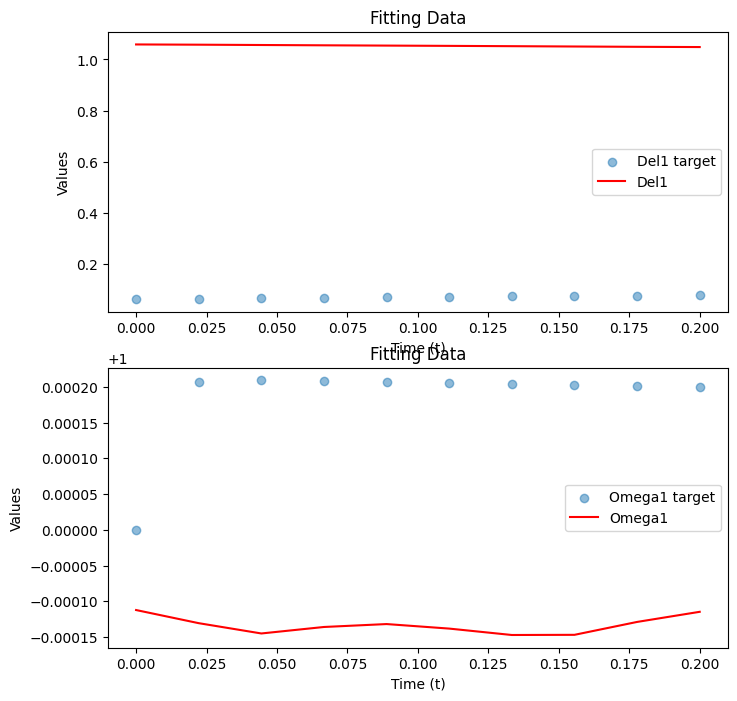

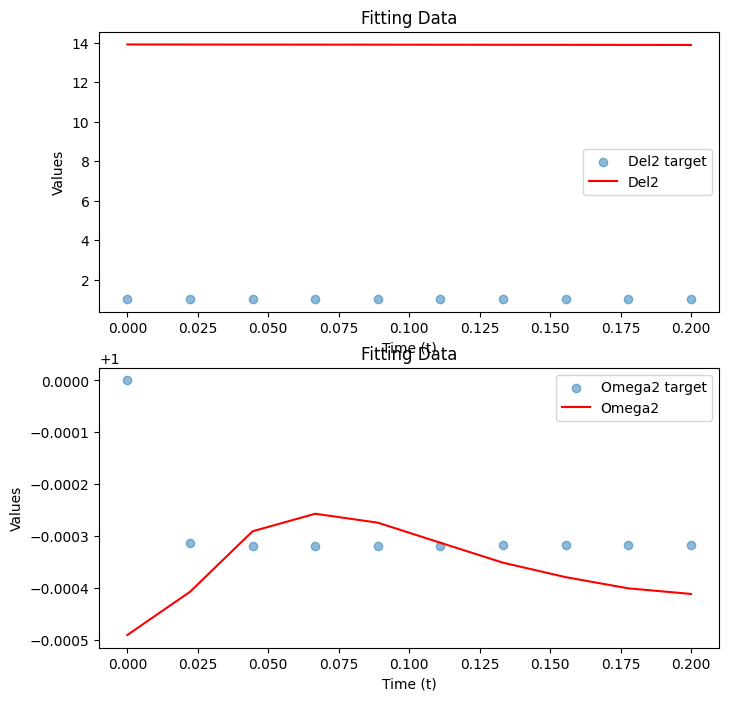

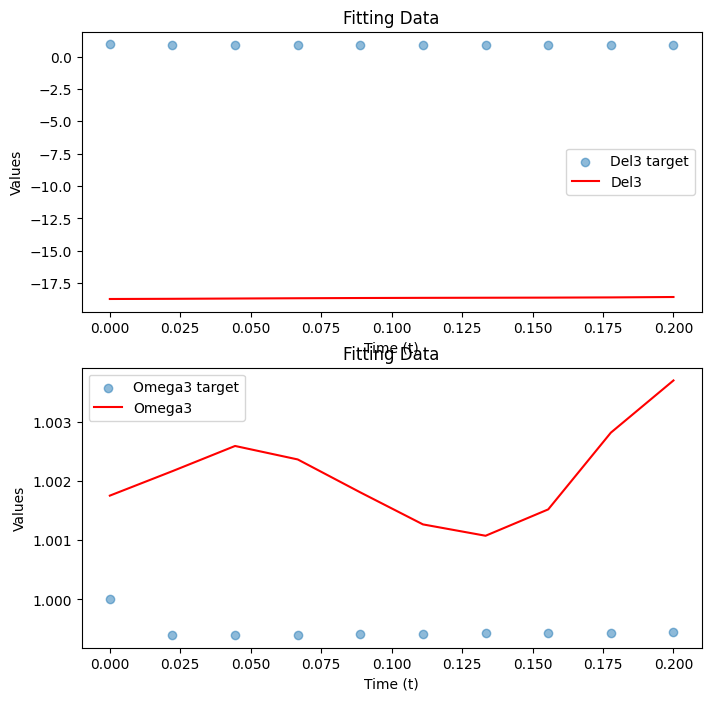

In [25]:
import matplotlib.pyplot as plt
delta_pred1,delta_pred2,delta_pred3 = calculate_deltas(m,t_data,best_param)
print(delta_pred1)

# delta1_omega1
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.scatter(t_data, del1_target_values, label='Del1 target', alpha=0.5)
# delta_pred1 = f(theta1,w1,t_data)
plt.plot(t_data, delta_pred1, 'r', label='Del1')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')



plt.subplot(2, 1, 2)
plt.scatter(t_data, omega1_target_values, label='Omega1 target', alpha=0.5)
delta_pred1_prime = np.gradient(delta_pred1, t_data)
omega_pred1 = (1/Ws)*delta_pred1_prime+1
plt.plot(t_data, omega_pred1, 'r', label='Omega1')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')




# delta2_omega2
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.scatter(t_data, del2_target_values, label='Del2 target', alpha=0.5)
# delta_pred2 = f(theta2,w2,t_data)
plt.plot(t_data, delta_pred2, 'r', label='Del2')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')

plt.subplot(2, 1, 2)
plt.scatter(t_data, omega2_target_values, label='Omega2 target', alpha=0.5)
delta_pred2_prime = np.gradient(delta_pred2, t_data)
omega_pred2 = (1/Ws)*delta_pred2_prime+1
plt.plot(t_data, omega_pred2, 'r', label='Omega2')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')



# delta3_omega3
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.scatter(t_data, del3_target_values, label='Del3 target', alpha=0.5)
# delta_pred3 = f(theta3,w3,t_data)
plt.plot(t_data, delta_pred3, 'r', label='Del3')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')

plt.subplot(2, 1, 2)
plt.scatter(t_data, omega3_target_values, label='Omega3 target', alpha=0.5)
delta_pred3_prime = np.gradient(delta_pred3, t_data)
omega_pred3 = (1/Ws)*delta_pred3_prime+1
plt.plot(t_data, omega_pred3, 'r', label='Omega3')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')

In [26]:
# # X = np.linspace(range_min, range_max, 50)

# # Change the plot size
# default_figsize = mpl.rcParamsDefault['figure.figsize']
# mpl.rcParams['figure.figsize'] = [2 * value for value in default_figsize]

# # delta_pred = plot_solution(m, N, X, res.x, lambda_random,'delta')
# delta_pred = plot_solution(m, N, X, best_param, lambda_random,'delta')

# plt.plot(X, y_delta_real, 'r', label='Analytical solution _delta')
# plt.legend()

# plt.figure()

# delta_pred = np.array(delta_pred)
# delta_prime = (delta_pred[2:] - delta_pred[:-2])/(2*dx)
# omega = delta_prime+ws
# plt.plot(X[1:-1], omega, 'b', label='prediction solution _omega')
# plt.plot(X, y_omega_real, 'r', label='Analytical solution _omega')
# # plt.legend()


# plt.show()

Text(0, 0.5, 'Loss function value')

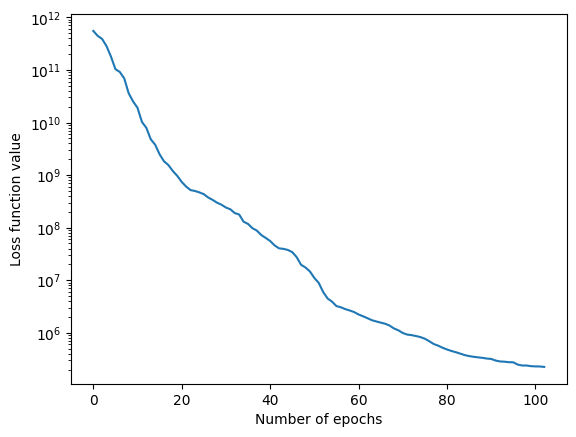

In [27]:

plt.plot([v[0] for v in loss_evolution])
plt.yscale("log")
plt.xlabel("Number of epochs")
plt.ylabel("Loss function value")